In [ ]:
import pandas as pd
import tweepy as tw
import re
!pip3 install pickle5
import pickle5 as pickle
with open('twitter_privacy1000.pkl', "rb") as fh:
  tweets = pickle.load(fh)
# tweets = pd.read_pickle('twitter_privacy1000.pkl')
print(len(tweets))
tweets['text_processed'] = tweets['text'].map(lambda x: re.sub('[,\.!?@]', '', x))

tweets['text_processed'] = tweets['text_processed'].map(lambda x: x.lower())

print(tweets['text_processed'].head())

     |████████████████████████████████| 256 kB 5.0 MB/s 
1000
0    left: samsung smarttv privacy policy warning u...
1    they can match my harris teeter purchases to m...
2    bombshell report by rolling stone: wray lied t...
3    how can a corporate privacy policy override th...
4    new eu laundering rules could be unworkable an...
Name: text_processed, dtype: object


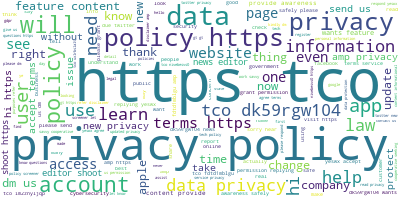

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(tweets['text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['tco', 'dk59rgw104', 'dm', 'hi', 'https','us','amp','dk','rgw'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = tweets.text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['left', 'samsung', 'smarttv', 'privacy', 'policy', 'warning', 'users', 'discuss', 'personal', 'info', 'front', 'tv', 'right', 'http', 'osywjykv']


In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]


In [ ]:
from pprint import pprint
# number of topics
num_topics = 8
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 8 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.029*"policy" + 0.025*"privacy" + 0.006*"data" + 0.006*"account" + '
  '0.005*"new" + 0.005*"due" + 0.004*"real" + 0.004*"twitter" + 0.004*"tech" + '
  '0.003*"information"'),
 (1,
  '0.048*"privacy" + 0.042*"policy" + 0.009*"please" + 0.008*"data" + '
  '0.005*"account" + 0.005*"new" + 0.005*"information" + 0.004*"contact" + '
  '0.004*"website" + 0.004*"learn"'),
 (2,
  '0.034*"privacy" + 0.030*"policy" + 0.008*"please" + 0.007*"content" + '
  '0.006*"terms" + 0.006*"permission" + 0.006*"yeswx" + 0.006*"news" + '
  '0.006*"data" + 0.005*"account"'),
 (3,
  '0.054*"privacy" + 0.047*"policy" + 0.014*"data" + 0.006*"information" + '
  '0.005*"please" + 0.004*"use" + 0.003*"new" + 0.003*"read" + 0.003*"terms" + '
  '0.003*"learn"'),
 (4,
  '0.029*"privacy" + 0.020*"policy" + 0.012*"terms" + 0.011*"please" + '
  '0.010*"like" + 0.007*"contact" + 0.007*"content" + 0.007*"feature" + '
  '0.007*"permission" + 0.007*"yeswx"'),
 (5,
  '0.031*"policy" + 0.029*"privacy" + 0.005*"know" +

In [ ]:
# Eval
from gensim import corpora

# gensim_dictionary = corpora.Dictionary(tweets['text_processed'])
# gensim_corpus = [gensim_dictionary.doc2bow(token, allow_update=True) for token in processed_data]
print('\nPerplexity:', lda_model.log_perplexity(corpus))

from gensim.models import CoherenceModel

coherence_score_lda = CoherenceModel(model=lda_model, texts=list(tweets['text_processed']), dictionary=id2word, coherence='c_v')
coherence_score = coherence_score_lda.get_coherence()   

print('\nCoherence Score:', coherence_score)


Perplexity: -8.14790966336335


/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:193: RuntimeWarning: invalid value encountered in true_divide
  numerator = (co_occur_count / num_docs) + EPSILON
/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:194: RuntimeWarning: invalid value encountered in true_divide
  denominator = (w_prime_count / num_docs) * (w_star_count / num_docs)
/usr/local/lib/python3.7/dist-packages/gensim/topic_coherence/direct_confirmation_measure.py:189: RuntimeWarning: invalid value encountered in true_divide
  co_doc_prob = co_occur_count / num_docs



Coherence Score: nan


In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9453,"policy, privacy, data, know, new, let, work, y...","[left, samsung, smarttv, privacy, policy, warn..."
1,1,2.0,0.9583,"privacy, policy, data, account, page, please, ...","[match, harris, teeter, purchases, twitter, ac..."
2,2,4.0,0.9708,"privacy, policy, data, please, account, contac...","[bombshell, report, rolling, stone, wray, lied..."
3,3,0.0,0.9650,"policy, privacy, data, know, new, let, work, y...","[corporate, privacy, policy, override, constit..."
4,4,2.0,0.9583,"privacy, policy, data, account, page, please, ...","[new, eu, laundering, rules, could, unworkable..."
5,5,6.0,0.9635,"privacy, policy, information, please, data, de...","[third, time, ftc, forced, company, destroy, a..."
6,6,0.0,0.9650,"policy, privacy, data, know, new, let, work, y...","[corporate, privacy, policy, override, constit..."
7,7,5.0,0.9687,"policy, privacy, data, please, provide, conten...","[monsoonuk, charliesnovella, dear, monsoonuk, ..."
8,8,1.0,0.9635,"privacy, policy, data, please, would, new, lik...","[giveaway, win, eurs, largest, euro, backed, s..."
9,9,4.0,0.9562,"privacy, policy, data, please, account, contac...","[hackers, increasingly, target, reputations, r..."


In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9742,"policy, privacy, data, know, new, let, work, year, apple, seeking","[johnmu, datachaz, also, know, small, business, coming, covid, tire, new, demands, covid, policy..."
1,1.0,0.9742,"privacy, policy, data, please, would, new, like, terms, account, agree","[elonmusk, first, safe, social, network, made, india, world, hftfj, sfye, user, get, verified, i..."
2,2.0,0.9742,"privacy, policy, data, account, page, please, information, contact, ecommerce, learn","[jumptradenft, beyondlifeclub, ramkumartweet, guardian_nft, vjmbmk, mbmk, apr, pm, kyc, process,..."
3,3.0,0.9770,"privacy, policy, please, terms, content, data, gt, learn, like, may","[hmkhan, officialdgispr, zartajgulwazir, imranriazkhan, imrankhanpti, insafpk, muradsaeedpti, fa..."
4,4.0,0.9844,"privacy, policy, data, please, account, contact, free, number, information, new","[realdoctort, thinkingsapien, gumbeauxmike, mark_i, angryfleas, shadowdroid, john_iwas_, admone,..."
5,5.0,0.9742,"policy, privacy, data, please, provide, content, news, information, personal, accept","[valueaddedrs, annetterobidoux, askebay, terms, service, link, privacy, policy, link, opens, new..."
6,6.0,0.9708,"privacy, policy, information, please, data, details, full, cybersecurity, account, name","[delaying, pays, abusing, privacy, credentials, labour, unacceptable, law, company, policy, ai, ..."
7,7.0,0.9810,"privacy, policy, know, tech, data, twitter, details, new, account, help","[mstratford, johnbking, free_to_prosper, unidir, wgeid, intlcrimcourt, courpenaleint, debtcrisis..."


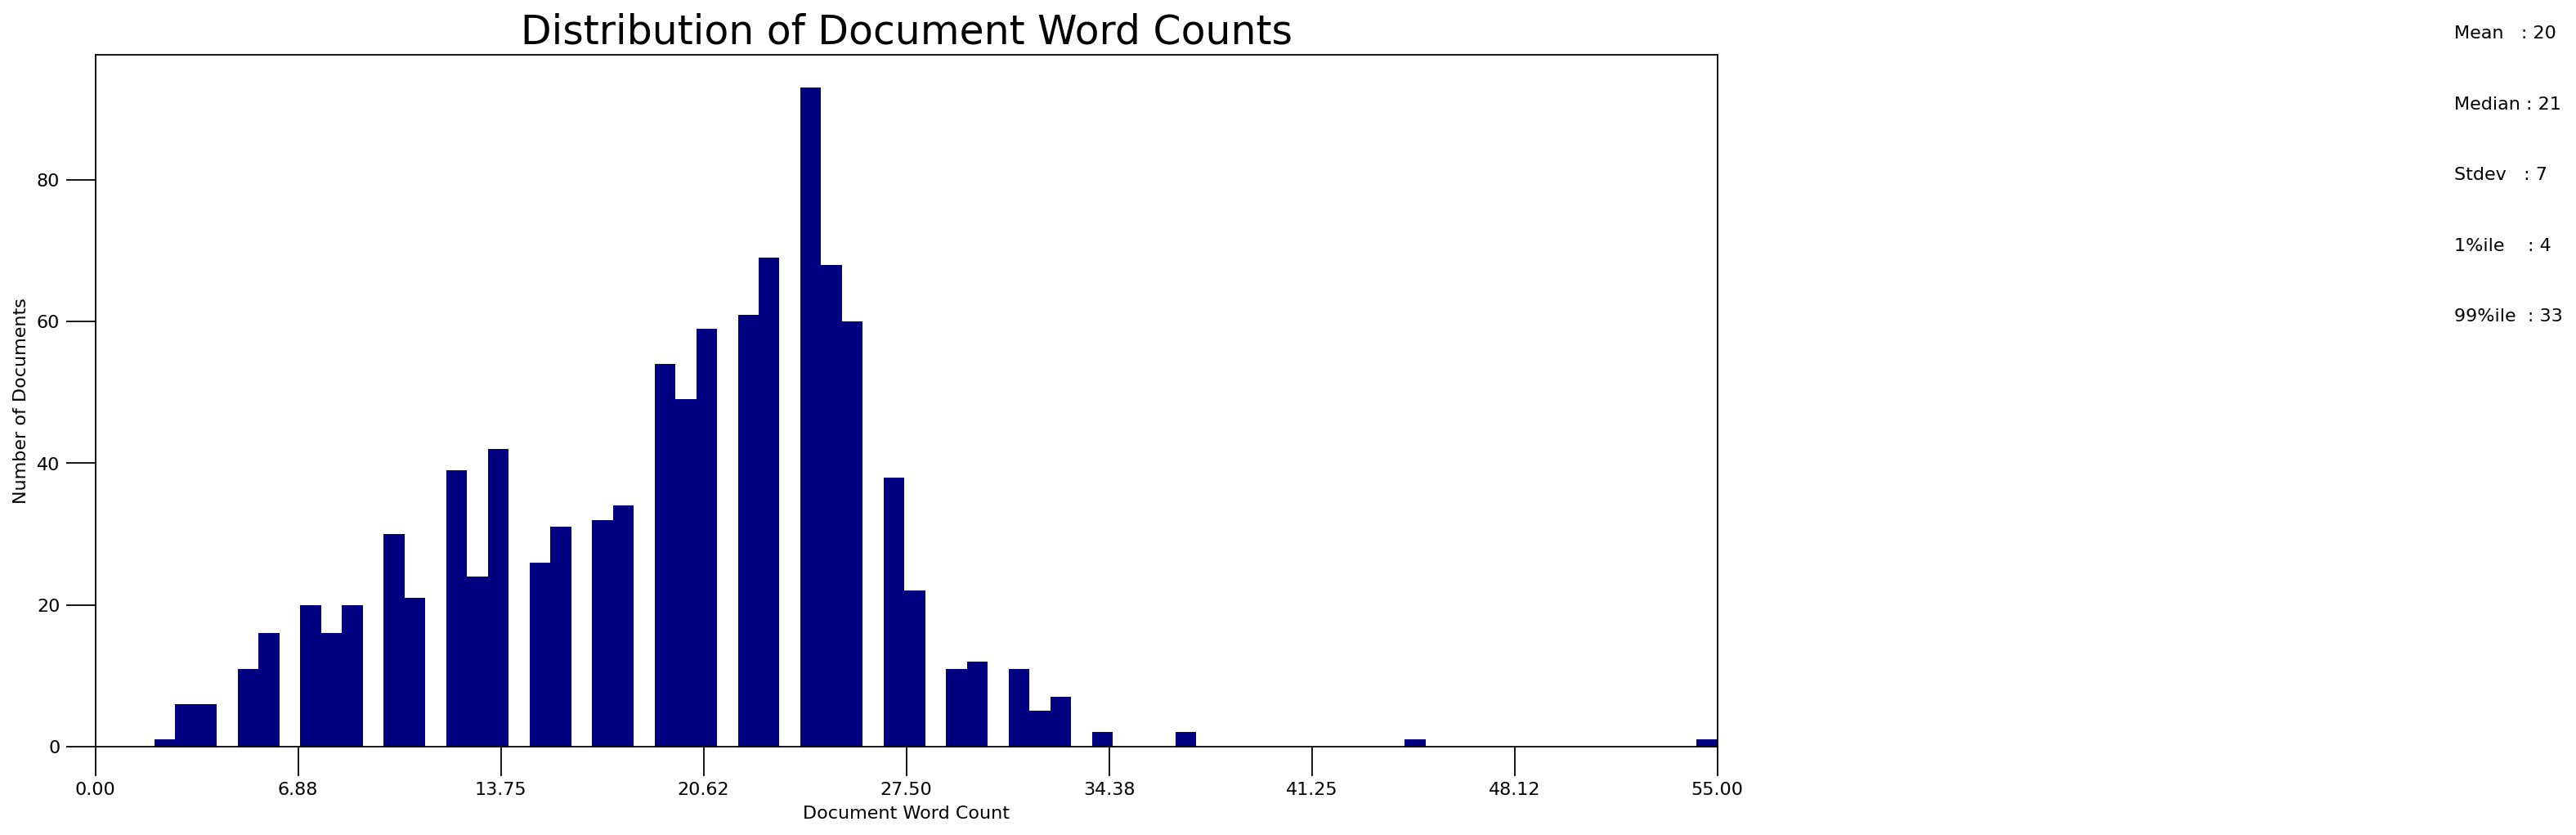

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 75, color='navy')
plt.text(80, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(80,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(80,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(80,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(80,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 55), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,55,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

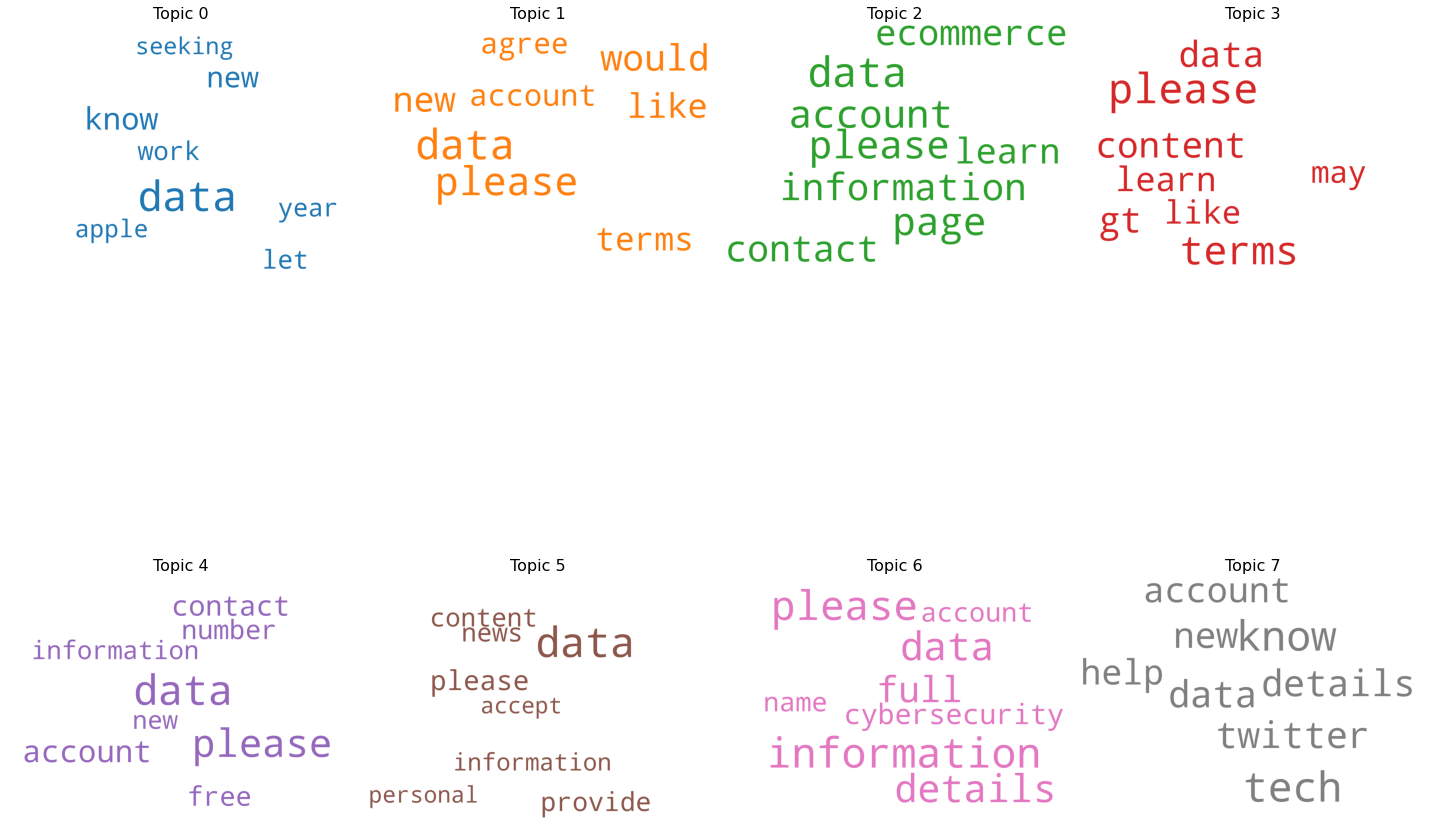

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 4, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    # print(topic_words)
    topic_words.pop('privacy')
    topic_words.pop('policy')
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

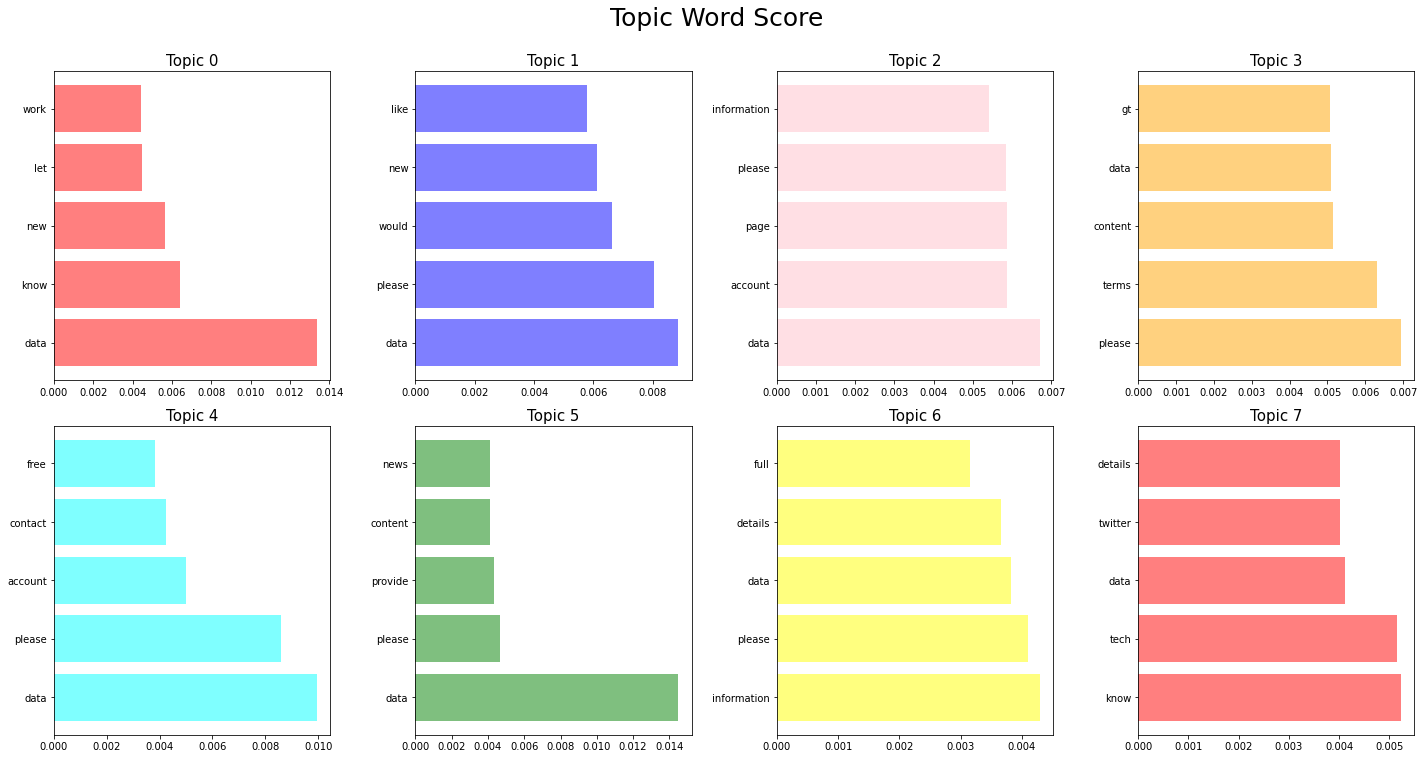

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20,10), sharex=False, sharey=False)
plt.title('Topic Word Score')
colors = ['red','blue','pink','orange','cyan','green','yellow','red']

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    # print(topic_words)
    topic_words.pop('privacy')
    topic_words.pop('policy')
    objects = list(topic_words.keys())[0:5]
    y_pos = np.arange(len(objects))
    val = list(topic_words.values())[0:5]
    plt.barh(y_pos, val, align='center', alpha=0.5, color=colors[i])
    plt.yticks(y_pos, objects)
    # plt.xlabel('Usage')
    plt.title('Topic ' + str(i), fontsize=15)

plt.suptitle('Topic Word Score', fontsize=25, y = 1.05)
plt.subplots_adjust(wspace=10, hspace=10)
# plt.axis('off')
# plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
topics

[(0,
  [('policy', 0.038318068),
   ('privacy', 0.035034858),
   ('data', 0.013370983),
   ('know', 0.006408555),
   ('new', 0.0056671808),
   ('let', 0.004460377),
   ('work', 0.0044306763),
   ('year', 0.004262994),
   ('apple', 0.0039729066),
   ('seeking', 0.0036439213)]),
 (1,
  [('privacy', 0.032257255),
   ('policy', 0.026337672),
   ('data', 0.008868199),
   ('please', 0.008048213),
   ('would', 0.006615935),
   ('new', 0.006129572),
   ('like', 0.0057752407),
   ('terms', 0.0053783627),
   ('account', 0.004539417),
   ('agree', 0.004258497)]),
 (2,
  [('privacy', 0.041651964),
   ('policy', 0.033172943),
   ('data', 0.0067080725),
   ('account', 0.0058621997),
   ('page', 0.005860023),
   ('please', 0.0058561666),
   ('information', 0.0054051266),
   ('contact', 0.005177677),
   ('ecommerce', 0.0049089426),
   ('learn', 0.004844426)]),
 (3,
  [('privacy', 0.04646584),
   ('policy', 0.042390008),
   ('please', 0.006948964),
   ('terms', 0.006308341),
   ('content', 0.0051344456

In [ ]:
!pip install pyLDAvis
import pyLDAvis
topics.visualize_barchart

     |████████████████████████████████| 1.7 MB 6.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=b75676dc8963552b4b8d103c332d31192c1d5a4915109666283294fd44d5b22a
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


AttributeError: ignored

LDA

In [ ]:
# !pip install pyLDAvis==2.1.2
# import pyLDAvis.gensim
# import pickle 
# import pyLDAvis
# # Visualize the topics
# pyLDAvis.enable_notebook()
# LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # # this is a bit time consuming - make the if statement True
# # # if you want to execute visualization prep yourself
# # if 1 == 1:
# LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
# with open(LDAvis_data_filepath, 'wb') as f:
#     pickle.dump(LDAvis_prepared, f)
# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
# LDAvis_prepared